# Load trained models and counterfactual results to do analysis.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from surrogate import rules

from utils.df_loader import load_adult_df, load_compas_df, load_german_df, load_diabetes_df, load_breast_cancer_df
from utils.preprocessing import preprocess_df
from sklearn.model_selection import train_test_split
from utils.dice import generate_dice_result, process_results
from utils.models import train_three_models, evaluation_test, save_three_models, load_lp_three_models
from utils.save import save_result_as_csv
from IPython.display import Image
import PIL
import pydotplus
from six import StringIO
from sklearn.tree import export_graphviz
from pydotplus import *


pd.options.mode.chained_assignment = None 

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)


TF version:  2.0.0
Eager execution enabled:  True


In [2]:
def get_location(scaler, col):
    if col in scaler.feature_names_in_:
        return np.where(scaler.feature_names_in_ == col)[0]
    
    else:
        raise Exception(f"Column [{col}] not a feature in this scaler, scaler features: {scaler.feature_names_in_}")


def get_scaled_value(scaler, col, X):
    loc=get_location(scaler, col)

    X *= scaler.scale_[loc]
    X += scaler.min_[loc]

    if scaler.clip:
        np.clip(X, scaler.feature_range[0][loc], scaler.feature_range[1][loc], out=X)
    
    return X[0]


def get_original_value(scaler, col, X):
    loc = get_location(scaler, col)

    X -= scaler.min_[loc]
    X /= scaler.scale_[loc]

    return X[0]

In [3]:
#### Select dataset ####'

dataset_name = 'compas' # [adult, german, compas]

if dataset_name == 'adult':
    dataset_loading_fn = load_adult_df
elif dataset_name == 'german':
    dataset_loading_fn = load_german_df
elif dataset_name == 'compas':
    dataset_loading_fn = load_compas_df
elif dataset_name == 'diabetes':
    dataset_loading_fn = load_diabetes_df
elif dataset_name == 'breast_cancer':
    dataset_loading_fn = load_breast_cancer_df
else:
    raise Exception("Unsupported dataset")

In [4]:
#### Load datafram info.
df_info = preprocess_df(dataset_loading_fn)
### Seperate to train and test set.
train_df, test_df = train_test_split(df_info.dummy_df, train_size=.8, random_state=seed, shuffle=True)
### Get training and testing array.
X_train = np.array(train_df[df_info.ohe_feature_names])
y_train = np.array(train_df[df_info.target_name])
X_test = np.array(test_df[df_info.ohe_feature_names])
y_test = np.array(test_df[df_info.target_name])
### Load models.
models = load_lp_three_models(X_train.shape[-1], dataset_name)

2022-07-09 15:17:10.036143: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-09 15:17:10.037127: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [5]:
#pip install pillow
#pip install dtreeviz
#pip install Graphviz
from dtreeviz.trees import *
from sklearn.tree import DecisionTreeClassifier
proto_dt = pd.read_csv(r'./datasets/eval_proto_compas_dt_result.csv')


In [6]:
original_compas = pd.read_csv(r'./datasets/COMPAS.csv')
original_compas

id                 name      first         last  \
0         1     miguel hernandez     miguel    hernandez   
1         3          kevon dixon      kevon        dixon   
2         4             ed philo         ed        philo   
3         5          marcu brown      marcu        brown   
4         6   bouthy pierrelouis     bouthy  pierrelouis   
...     ...                  ...        ...          ...   
7209  10996        steven butler     steven       butler   
7210  10997      malcolm simmons    malcolm      simmons   
7211  10999      winston gregory    winston      gregory   
7212  11000          farrah jean     farrah         jean   
7213  11001  florencia sanmartin  florencia    sanmartin   

     compas_screening_date     sex         dob  age          age_cat  \
0               2013-08-14    Male  1947-04-18   69  Greater than 45   
1               2013-01-27    Male  1982-01-22   34          25 - 45   
2               2013-04-14    Male  1991-05-14   24     Less than 25   
3               2013-01-13    Male  1993-01-21   23     Less than 25   
4               2013-03-26    Male  1973-01-22   43          25 - 45   
...                    ...     ...         ...  ...              ...   
7209            2013-11-23    Male  1992-07-17   23     Less than 25   
7210            2014-02-01    Male  1993-03-25   23     Less than 25   
7211            2014-01-14    Male  1958-10-01   57  Greater than 45   
7212            2014-03-09  Female  1982-11-17   33          25 - 45   
7213            2014-06-30  Female  1992-12-18   23     Less than 25   

                  race  ...  v_decile_score  v_score_text  v_screening_date  \
0                Other  ...               1           Low        2013-08-14   
1     African-American  ...               1           Low        2013-01-27   
2     African-American  ...               3           Low        2013-04-14   
3     African-American  ...               6        Medium        2013-01-13   
4                Other  ...               1           Low        2013-03-26   
...                ...  ...             ...           ...               ...   
7209  African-American  ...               5        Medium        2013-11-23   
7210  African-American  ...               5        Medium        2014-02-01   
7211             Other  ...               1           Low        2014-01-14   
7212  African-American  ...               2           Low        2014-03-09   
7213          Hispanic  ...               4           Low        2014-06-30   

      in_custody  out_custody  priors_count.1 start   end event two_year_recid  
0     2014-07-07   2014-07-14               0     0   327     0              0  
1     2013-01-26   2013-02-05               0     9   159     1              1  
2     2013-06-16   2013-06-16               4     0    63     0              1  
3            NaN          NaN               1     0  1174     0              0  
4            NaN          NaN               2     0  1102     0              0  
...          ...          ...             ...   ...   ...   ...            ...  
7209  2013-11-22   2013-11-24               0     1   860     0              0  
7210  2014-01-31   2014-02-02               0     1   790     0              0  
7211  2014-01-13   2014-01-14               0     0   808     0              0  
7212  2014-03-08   2014-03-09               3     0   754     0              0  
7213  2015-03-15   2015-03-15               2     0   258     0              1  

[7214 rows x 53 columns]

In [7]:
original_compas

id                 name      first         last  \
0         1     miguel hernandez     miguel    hernandez   
1         3          kevon dixon      kevon        dixon   
2         4             ed philo         ed        philo   
3         5          marcu brown      marcu        brown   
4         6   bouthy pierrelouis     bouthy  pierrelouis   
...     ...                  ...        ...          ...   
7209  10996        steven butler     steven       butler   
7210  10997      malcolm simmons    malcolm      simmons   
7211  10999      winston gregory    winston      gregory   
7212  11000          farrah jean     farrah         jean   
7213  11001  florencia sanmartin  florencia    sanmartin   

     compas_screening_date     sex         dob  age          age_cat  \
0               2013-08-14    Male  1947-04-18   69  Greater than 45   
1               2013-01-27    Male  1982-01-22   34          25 - 45   
2               2013-04-14    Male  1991-05-14   24     Less than 25   
3               2013-01-13    Male  1993-01-21   23     Less than 25   
4               2013-03-26    Male  1973-01-22   43          25 - 45   
...                    ...     ...         ...  ...              ...   
7209            2013-11-23    Male  1992-07-17   23     Less than 25   
7210            2014-02-01    Male  1993-03-25   23     Less than 25   
7211            2014-01-14    Male  1958-10-01   57  Greater than 45   
7212            2014-03-09  Female  1982-11-17   33          25 - 45   
7213            2014-06-30  Female  1992-12-18   23     Less than 25   

                  race  ...  v_decile_score  v_score_text  v_screening_date  \
0                Other  ...               1           Low        2013-08-14   
1     African-American  ...               1           Low        2013-01-27   
2     African-American  ...               3           Low        2013-04-14   
3     African-American  ...               6        Medium        2013-01-13   
4                Other  ...               1           Low        2013-03-26   
...                ...  ...             ...           ...               ...   
7209  African-American  ...               5        Medium        2013-11-23   
7210  African-American  ...               5        Medium        2014-02-01   
7211             Other  ...               1           Low        2014-01-14   
7212  African-American  ...               2           Low        2014-03-09   
7213          Hispanic  ...               4           Low        2014-06-30   

      in_custody  out_custody  priors_count.1 start   end event two_year_recid  
0     2014-07-07   2014-07-14               0     0   327     0              0  
1     2013-01-26   2013-02-05               0     9   159     1              1  
2     2013-06-16   2013-06-16               4     0    63     0              1  
3            NaN          NaN               1     0  1174     0              0  
4            NaN          NaN               2     0  1102     0              0  
...          ...          ...             ...   ...   ...   ...            ...  
7209  2013-11-22   2013-11-24               0     1   860     0              0  
7210  2014-01-31   2014-02-02               0     1   790     0              0  
7211  2014-01-13   2014-01-14               0     0   808     0              0  
7212  2014-03-08   2014-03-09               3     0   754     0              0  
7213  2015-03-15   2015-03-15               2     0   258     0              1  

[7214 rows x 53 columns]

In [8]:

# VISUALISE_DECISION_TREE_PATH
# 
def visualize_decision_tree_path( clf, graph, instance, indx, exp_type, path ):  

  for i, node in enumerate(graph.get_node_list()):
    if node.get_attributes().get('label') is None:
        continue

    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')
    
    lable_str = node.get_attributes()['label']  
    feature_value_str = (lable_str.split("<br/>")[0]).replace('<','')
    feature_name = feature_value_str.split(" ")[0]
    if feature_name in df_info.scaler.feature_names_in_:
      feature_value = float(feature_value_str.split(" ")[-1])
      original_value = get_original_value(df_info.scaler, feature_name , feature_value)
      #print(f"name: {feature_name}. value: {feature_value}, original_value: {original_value}")
      original_lable_str = lable_str.replace(feature_value_str, ' '.join([*(feature_value_str.split(' '))[:-1],f'{original_value:.2f}']))
      node.set('label', original_lable_str)
    #raise StopIteration()

  samples = instance
  
  decision_paths = clf.decision_path( [samples] )

  for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
      if node_value == 0:
        continue
      node = graph.get_node(str(n))[0]            
      node.set_fillcolor('green')
      labels = node.get_attributes()['label'].split('<br/>')
      for i, label in enumerate(labels):
        if label.startswith('samples = '):
          labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)
      
      node.set('label', '<br/>'.join(labels))

  filename = path
  graph.write_png(filename)

  im = PIL.Image.open(filename)
  return im


# EXTRACT_DECISION_PATH
# 
def extract_decision_path(clf, graph, instance ):

  #samples = instance['scaled_vector']
  #decision_paths = clf.decision_path( [samples] )
  samples = instance
  decision_paths = clf.decision_path( [samples] )

  for decision_path in decision_paths:
    path = []
    for n, node_value in enumerate(decision_path.toarray()[0]):
      if node_value == 0:
        continue

      node = graph.get_node(str(n))[0]
      labels = node.get_attributes()['label'].split('<br/>')
      labels.pop(1)
      try:
        labels.remove("samples = 1")
        labels.remove("samples = 0")
        labels.remove("gini = 0.0")
      except ValueError:
        labels
      path.append(labels)
  return path

def export_decision_tree(clf, class_names, DATASET_NAME, path):
  dot_data = StringIO()
  export_graphviz(clf, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True, feature_names = feature_names,
                  class_names=class_names)

  # convert to png format
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  graph.write_png(path)
  return graph


In [9]:
test1 = proto_dt.nsmallest(1,['L2'])
test1

Unnamed: 0  Unnamed: 0.1  scaled_input_age  scaled_input_priors_count  \
50          50             0          0.115385                   0.105263   

    scaled_input_days_b_screening_arrest  scaled_input_is_recid  \
50                                     1                      0   

    scaled_input_is_violent_recid  scaled_input_two_year_recid  \
50                              0                            0   

    scaled_input_length_of_stay scaled_input_age_cat  ... origin_cf_sex  \
50                           33              25 - 45  ...        Female   

      origin_cf_race origin_cf_c_charge_degree origin_cf_class        L1  \
50  African-American                         F      Medium-Low  2.220648   

          L2  Sparsity  Realistic       MAD  Mahalanobis  
50  1.422812       4.0       TRUE  0.570672     0.791855  

[1 rows x 61 columns]

In [10]:
test = proto_dt.nlargest(1,['L2'])
test

Unnamed: 0  Unnamed: 0.1  scaled_input_age  scaled_input_priors_count  \
5           5             0          0.051282                   0.157895   

   scaled_input_days_b_screening_arrest  scaled_input_is_recid  \
5                                   168                      1   

   scaled_input_is_violent_recid  scaled_input_two_year_recid  \
5                              0                            1   

   scaled_input_length_of_stay scaled_input_age_cat  ... origin_cf_sex  \
5                           62         Less than 25  ...        Female   

     origin_cf_race origin_cf_c_charge_degree origin_cf_class        L1  \
5  African-American                         F            High  6.209177   

         L2  Sparsity  Realistic       MAD  Mahalanobis  
5  2.455109       8.0       TRUE  0.891942      1.41181  

[1 rows x 61 columns]

In [11]:
#### import evaluation function.
from utils.evaluation import prepare_evaluation_dict
input_and_cf = prepare_evaluation_dict(proto_dt, df_info)


clf=models['dt']
#clf = DecisionTreeClassifier()
class_names = ["No", "Yes"]



In [12]:
#filepath = PATH + 'Whitebox_Model/explanations/' + DATASET_NAME.replace(".csv", "")+ '/Decision_Tree/' + exp_type + '/decision_tree_general_' + str(INDX) + '.png'
PATH = "GitHub/Counterfactual-benchmark/"
dataset_name = 'compas' # [adult, german, compas]
filepath = "/Users/yu-liangchou/Desktop/cf_experiment/tree.png"
#feature_names=df_info.feature_names
feature_names=df_info.ohe_feature_names
graph = export_decision_tree(clf, class_names, dataset_name, filepath) 

#Image(graph.create_png())

[Text(0.5588732114467408, 0.9545454545454546, 'node #0\npriors_count <= 0.118\ngini = 0.407\nsamples = 5771\nvalue = [1643, 4128]'),
 Text(0.28989467408585057, 0.8636363636363636, 'node #1\nage <= 0.071\ngini = 0.307\nsamples = 4288\nvalue = [813, 3475]'),
 Text(0.12922297297297297, 0.7727272727272727, 'node #2\npriors_count <= 0.039\ngini = 0.487\nsamples = 910\nvalue = [383, 527]'),
 Text(0.0815779014308426, 0.6818181818181818, 'node #3\nlength_of_stay <= 0.002\ngini = 0.453\nsamples = 679\nvalue = [235, 444]'),
 Text(0.04153418124006359, 0.5909090909090909, 'node #4\nrace_African-American <= 0.5\ngini = 0.412\nsamples = 445\nvalue = [129, 316]'),
 Text(0.025437201907790145, 0.5, 'node #5\ndays_b_screening_arrest <= 0.006\ngini = 0.319\nsamples = 186\nvalue = [37, 149]'),
 Text(0.022257551669316374, 0.4090909090909091, 'node #6\ndays_b_screening_arrest <= 0.001\ngini = 0.294\nsamples = 173\nvalue = [31, 142]'),
 Text(0.01589825119236884, 0.3181818181818182, 'node #7\nis_violent_recid

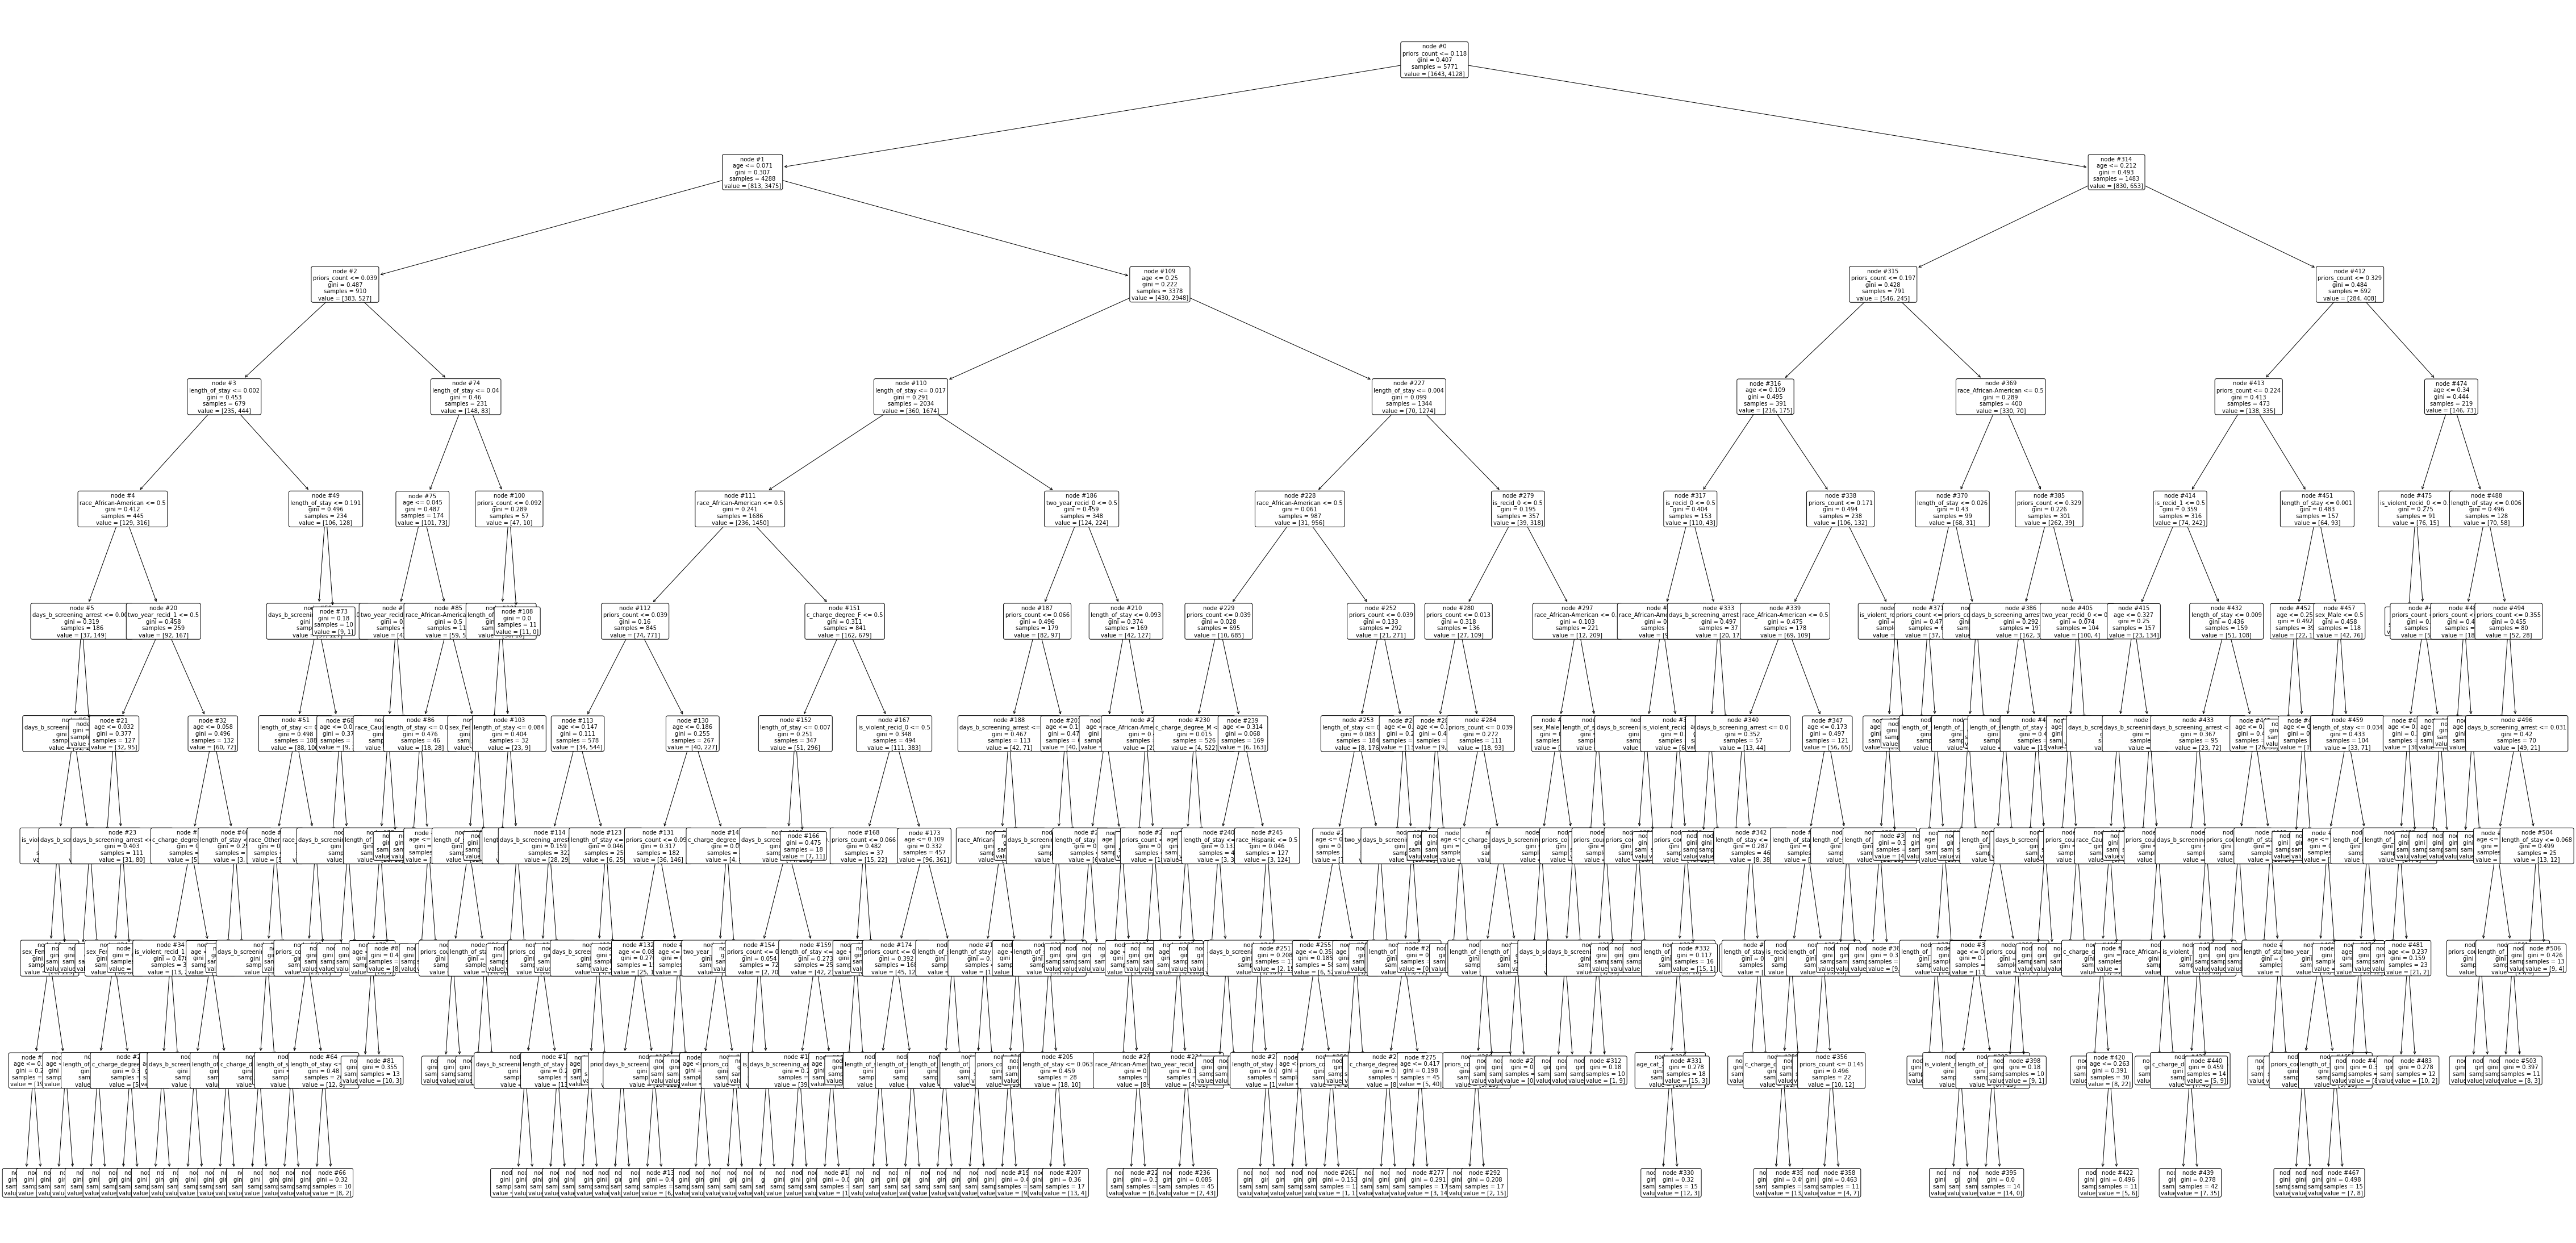

In [13]:
#### Plot the dt tree.
from sklearn import tree
import matplotlib.pyplot as plt
plt.figure(figsize=(80,40))
tree.plot_tree(models['dt'], fontsize=10, feature_names=df_info.ohe_feature_names, node_ids=True,rounded=True )
#If you need to colored the class >> filled=True


In [14]:
#### retrieve the input and cf vectors.
proto_input = input_and_cf['input'].loc[5]
proto_cf = input_and_cf['cf'].loc[5]

In [15]:
#### Present the decision path
tree_path = extract_decision_path(clf, graph, proto_input)
tree_path

[['<priors_count &le; 0.118',
  'samples = 5771',
  'value = [1643, 4128]',
  'class = Yes>'],
 ['<age &le; 0.212', 'samples = 1483', 'value = [830, 653]', 'class = No>'],
 ['<priors_count &le; 0.197',
  'samples = 791',
  'value = [546, 245]',
  'class = No>'],
 ['<age &le; 0.109', 'samples = 391', 'value = [216, 175]', 'class = No>'],
 ['<is_recid_0 &le; 0.5', 'samples = 153', 'value = [110, 43]', 'class = No>'],
 ['<race_African-American &le; 0.5',
  'samples = 116',
  'value = [90, 26]',
  'class = No>'],
 ['<days_b_screening_arrest &le; 0.025',
  'samples = 40',
  'value = [25, 15]',
  'class = No>'],
 ['<gini = 0.18', 'value = [9, 1]', 'class = No>']]

In [16]:
decisions, pred, leaf_id = rules.get_decision_process(np.array(proto_input).reshape(1, -1), models['dt'], df_info.ohe_feature_names)
print(leaf_id)


decision node 0 : (x [priors_count] = 0.157894737) > 0.1184210553765297)
decision node 314 : (x [age] = 0.051282051) <= 0.21153846383094788)
decision node 315 : (x [priors_count] = 0.157894737) <= 0.19736842066049576)
decision node 316 : (x [age] = 0.051282051) <= 0.10897435992956161)
decision node 317 : (x [is_recid_0] = 0.0) <= 0.5)
decision node 318 : (x [race_African-American] = 0.0) <= 0.5)
decision node 319 : (x [days_b_screening_arrest] = 168.0) > 0.025070955976843834)
323


In [17]:
decisions, pred, leaf_id = rules.get_decision_process(np.array(proto_cf).reshape(1, -1), models['dt'], df_info.ohe_feature_names)
print(leaf_id)

decision node 0 : (x [priors_count] = 0.0) <= 0.1184210553765297)
decision node 1 : (x [age] = 0.0) <= 0.07051282376050949)
decision node 2 : (x [priors_count] = 0.0) <= 0.03947368450462818)
decision node 3 : (x [length_of_stay] = 2.3187795) > 0.0018773467163555324)
decision node 49 : (x [length_of_stay] = 2.3187795) > 0.19086357951164246)
73


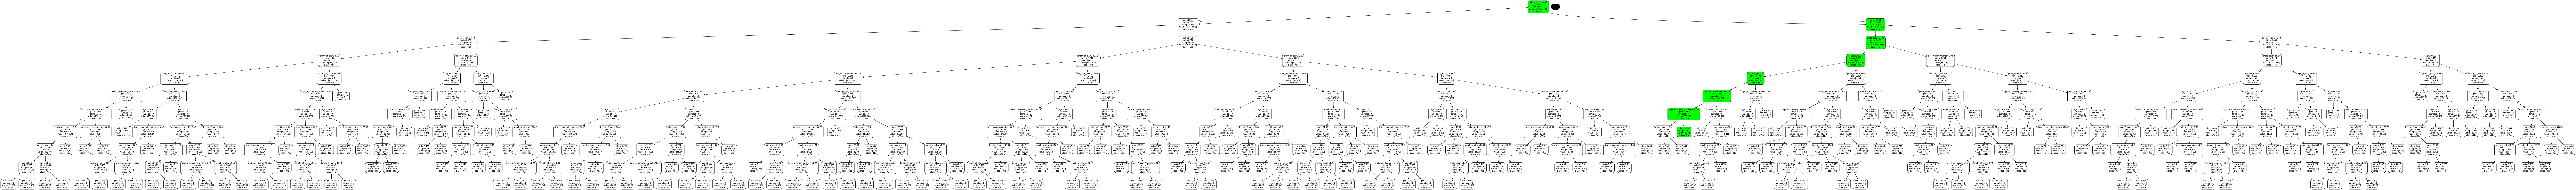

In [18]:
INDX = 5
exp_type = "true_positives"
#instance = new_min_l2_instance_instance_arr

img = visualize_decision_tree_path( clf, export_decision_tree(clf, class_names, dataset_name, filepath), proto_input, INDX, 'true_positives', filepath)
img



In [19]:
len(df_info.ohe_feature_names)

23

In [20]:
feature_names=df_info.ohe_feature_names
totoal_ohe_feature_names = len(feature_names)
totoal_ohe_feature_names

23

In [21]:
totoal_ohe_feature_names

23

In [22]:
feature_names

['age',
 'priors_count',
 'days_b_screening_arrest',
 'length_of_stay',
 'age_cat_25 - 45',
 'age_cat_Greater than 45',
 'age_cat_Less than 25',
 'sex_Female',
 'sex_Male',
 'race_African-American',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Native American',
 'race_Other',
 'c_charge_degree_F',
 'c_charge_degree_M',
 'is_recid_0',
 'is_recid_1',
 'is_violent_recid_0',
 'is_violent_recid_1',
 'two_year_recid_0',
 'two_year_recid_1']

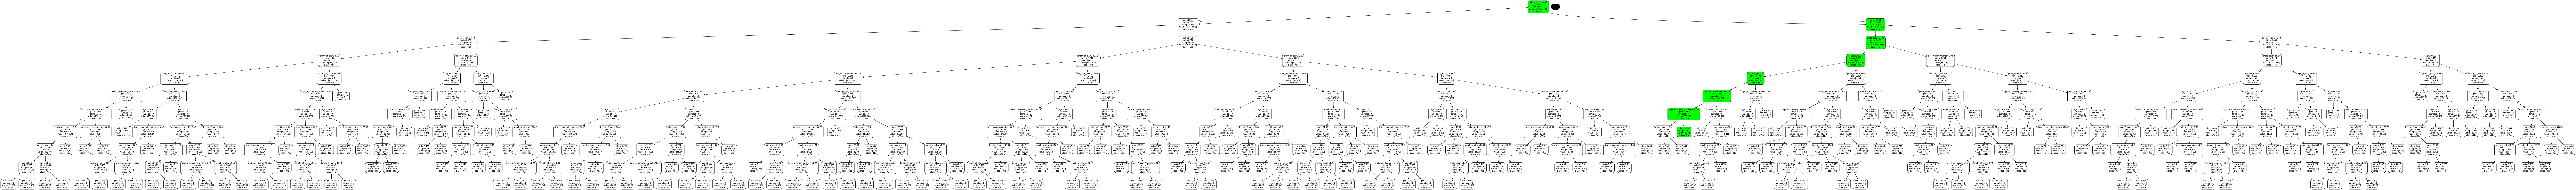

In [23]:
#exp_type = "L2_max"
INDX = 5
#instance = instance
#exp_type = "true_positives"
#instance = new_min_l2_instance_instance_arr

img = visualize_decision_tree_path( clf,  export_decision_tree(clf, class_names, dataset_name, filepath), proto_input, INDX, 'true_positives', filepath)
img

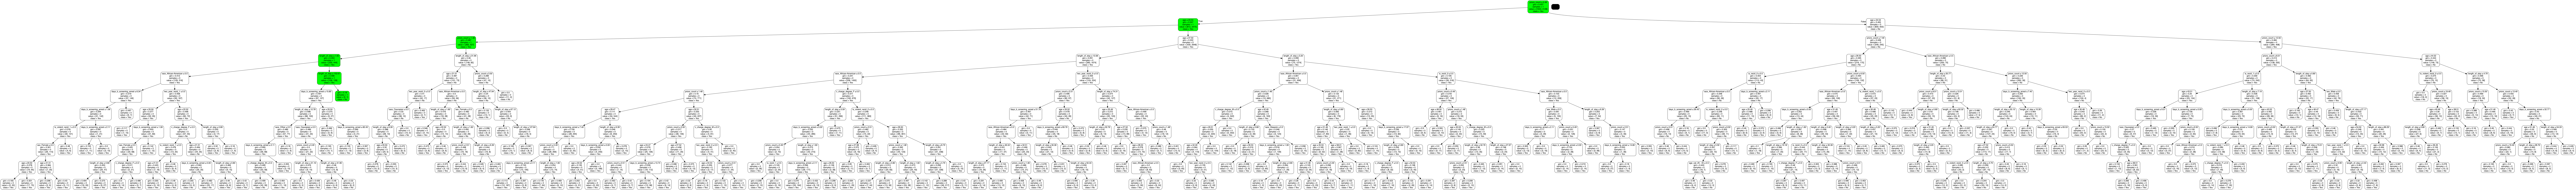

In [24]:
#exp_type = "L2_max"
INDX = 5
#instance = instance
#exp_type = "true_positives"
#instance = new_min_l2_instance_instance_arr

img = visualize_decision_tree_path( clf,  export_decision_tree(clf, class_names, dataset_name, filepath), proto_cf, INDX, 'true_positives', filepath)
img

In [25]:
from dtreeviz.trees import *
from sklearn.tree import DecisionTreeClassifier

In [26]:
# cat + numerical

proto_cf

age                        0.000000
priors_count               0.000000
days_b_screening_arrest    4.436658
length_of_stay             2.318780
age_cat_25 - 45            1.000000
age_cat_Greater than 45    0.000000
age_cat_Less than 25       0.000000
sex_Female                 1.000000
sex_Male                   0.000000
race_African-American      1.000000
race_Asian                 0.000000
race_Caucasian             0.000000
race_Hispanic              0.000000
race_Native American       0.000000
race_Other                 0.000000
c_charge_degree_F          1.000000
c_charge_degree_M          0.000000
is_recid_0                 0.000000
is_recid_1                 1.000000
is_violent_recid_0         1.000000
is_violent_recid_1         0.000000
two_year_recid_0           0.000000
two_year_recid_1           1.000000
Name: 5, dtype: float64

In [27]:
# tree_model = clf 
# x_data = X_train
# y_data = y_train
# target_name = 'target'
# feature_names=df_info.feature_names
# class_names=class_names
# X=proto_cf
# tree_index = None

# shadow_tree = ShadowDecTree.get_shadow_tree(
#     tree_model, x_data, y_data, feature_names, target_name, class_names, tree_index
# )

# shadow_tree.feature_names


In [28]:
viz = dtreeviz(clf, 
               x_data=X_train,
               y_data=y_train,
               target_name='target',
               # feature_names=df_info.feature_names,
               feature_names=df_info.ohe_feature_names, 
               class_names=class_names,
               title="Decison Tree - COMPAS with decision path",
               #orientation="LR", 
               #X=arr,
               X=proto_cf, # B1. value not acceptable by this function.
               # scale=.3,
               max_X_features_TD= 1,
               max_X_features_LR=1, 
               show_just_path=True,
               #X=X_test[0]
               
               )

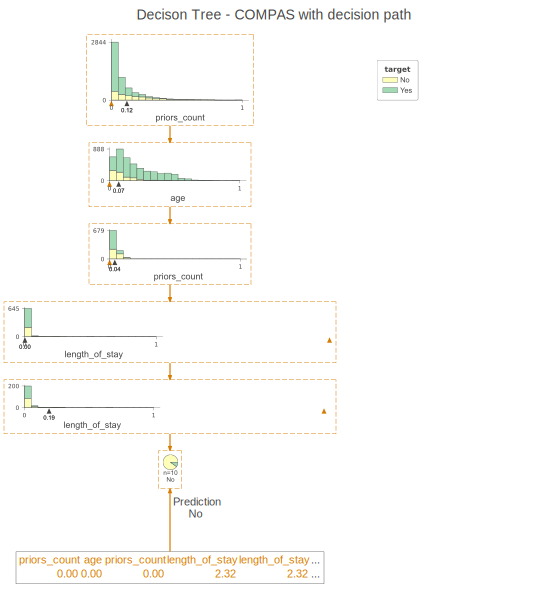

In [29]:
viz

In [30]:
viz.save_svg()

'/var/folders/cj/76jxqn71757384mssvb297jw0000gn/T/DTreeViz_51828.svg'